<a href="https://colab.research.google.com/github/Azhar-ali7/Skin_cancer_classification_using_cnn/blob/main/Skin_Cancer_Classification_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Essential Libraries

In [1]:
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from keras.applications import Xception,VGG16,ResNet50
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
%matplotlib inline

##Loading the dataset

###CSV

In [2]:
# path to the dataset in drive
data_path = "/content/drive/MyDrive/Project_files/Data"

# Load the CSV file
df = pd.read_csv(os.path.join(data_path, "HAM10000_metadata.csv"))

In [3]:
# Display the first five rows of the dataframe
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


###Images

In [4]:
# Loading the images path
images_path = {os.path.splitext(os.path.basename(x))[0]:x for x in glob.glob(os.path.join(data_path,'*','*.jpg'))}

##Data Preprocessing

In [5]:
# Encoding target values
cancer_type = {
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [6]:
# Adding extra columns and appending the required created columns in final dataframe
df['path'] = df['image_id'].map(images_path.get)
df['cell_type'] = df['dx'].map(cancer_type.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [7]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Project_files/Data/HAM1...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Project_files/Data/HAM1...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Project_files/Data/HAM1...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Project_files/Data/HAM1...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/Project_files/Data/HAM1...,Benign keratosis-like lesions,2


In [8]:
df.describe()

,age,cell_type_idx
count,9958.000000,10015.000000
mean,51.863828,3.623964
std,16.968614,1.208859
min,0.000000,0.000000
25%,40.000000,4.000000
50%,50.000000,4.000000
75%,65.000000,4.000000
max,85.000000,6.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


In [10]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [11]:
df['age'].fillna((df['age'].mean()), inplace=True)

In [12]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

<Axes: >

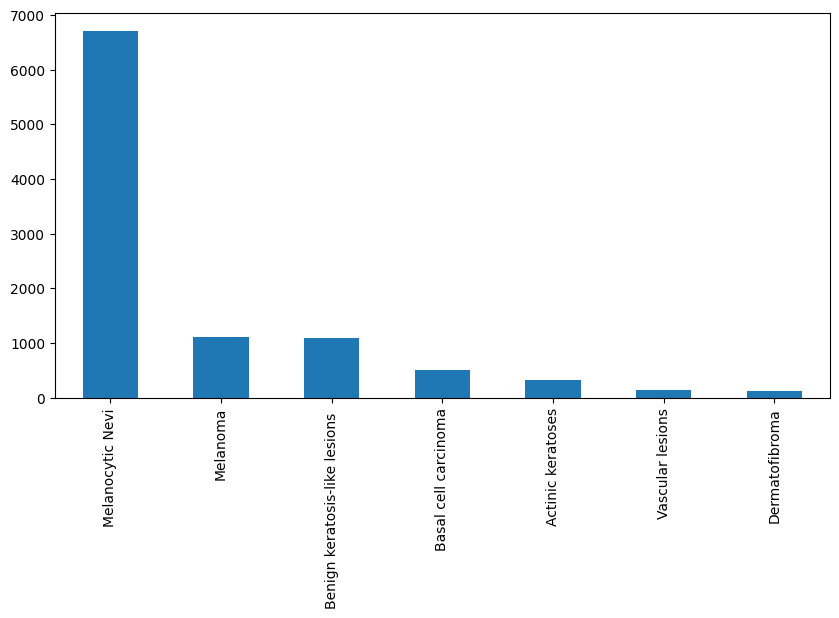

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<Axes: >

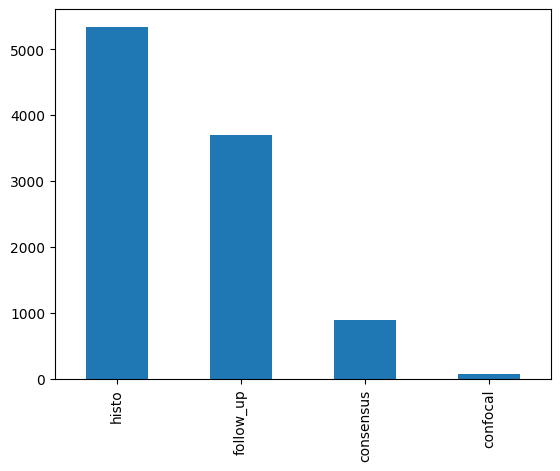

In [14]:
df['dx_type'].value_counts().plot(kind='bar')

<Axes: >

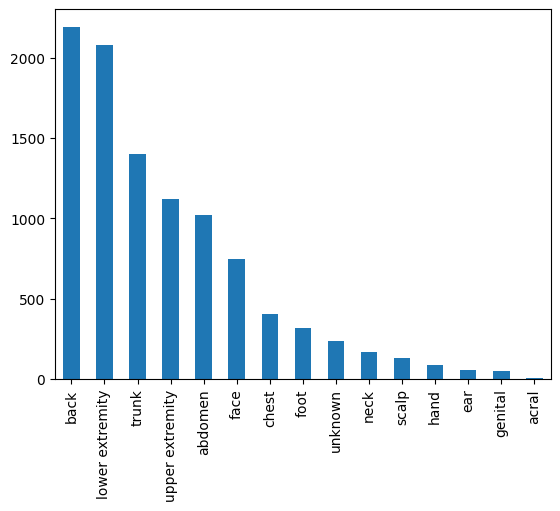

In [15]:
df['localization'].value_counts().plot(kind='bar')

In [16]:
# Image Reading and Resizing.
image_size = (71,71)

# function
def read_img(img_path):
  '''
   this function is for reading and preprocessing an image given its file path
  '''
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,image_size)
  return img


In [17]:
train_img = []

for img_name in tqdm(df['path'].values):
  train_img.append(read_img(img_name))

100%|██████████| 10015/10015 [21:49<00:00,  7.65it/s]


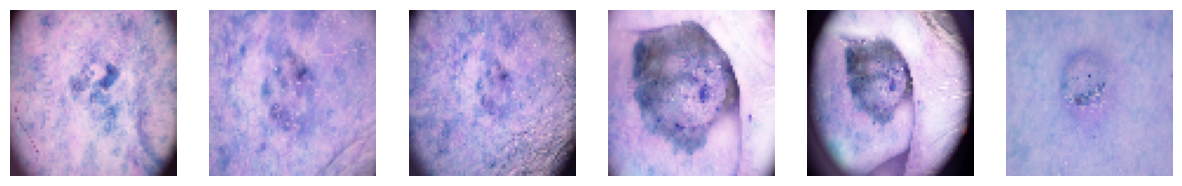

In [18]:
#Visulaizing the images
plt.figure(figsize=(15,12))
for i in range(1,7,1):
    plt.subplot(1,6,i)
    plt.imshow(train_img[i])
    plt.axis('off')
plt.show()

In [19]:
# Convert the list to a NumPy array
X = np.array(train_img)

# Normalize the pixel values
# RGB channel values are in range [0,255]
X = X / 255.0

In [20]:
# shape of numpy array
print(X.shape)

(10015, 71, 71, 3)


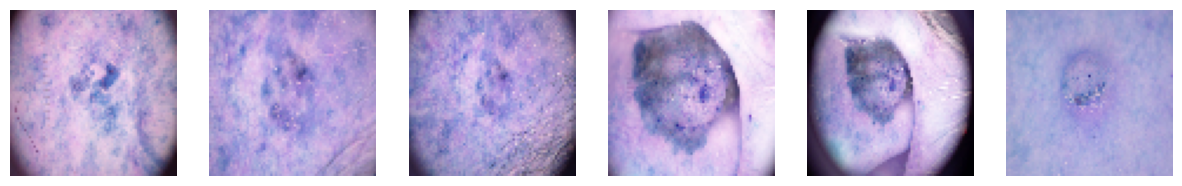

In [21]:
#Visulaizing the normalized images

plt.figure(figsize=(15,12))
for i in range(1,7,1):
    plt.subplot(1,6,i)
    plt.imshow(X[i])
    plt.axis('off')
plt.show()

In [22]:
# Creating Target
y = np.array(df['cell_type_idx'])

In [23]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42,stratify=y)

x_train,x_val,y_train,y_val =  train_test_split(x_train,y_train,test_size=0.10,random_state=42,stratify=y_train)

In [24]:
# One-Hot Encoding values
y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val , num_classes=7)

In [25]:
# Defining base model using Xception module from Keras
training_shape = (71,71,3)

base_model = Xception(include_top=False,weights='imagenet',input_shape = training_shape)

# Training all layers from scratch
for layer in base_model.layers:
    layer.trainable = True

83683744/83683744 [==============================] - 0s 0us/step


In [26]:
#Adding layers at end
n_classes = 7
model = base_model.output
model = Flatten()(model)
model = Dense(128)(model)
model = Dropout(0.5)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
output = Dense(n_classes, activation='softmax')(model)
model = Model(inputs=base_model.input, outputs=output)

In [27]:
# Compile the model
model.compile(optimizer = Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 71, 71, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 35, 35, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 35, 35, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 35, 35, 32)   0           ['block1_conv1_bn[0][0]']    

In [29]:
# Defining callback Methods
n_epoch = 50

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=2,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=2, mode='auto')

In [30]:
# Fitting the model
history = model.fit(x_train,
                    y_train,
                    epochs=n_epoch,
                    callbacks=[reduce_lr,early_stop],
                    validation_data=(x_val,y_val),
                    verbose = 2
                   )

Epoch 1/50
226/226 - 62s - loss: 0.9010 - accuracy: 0.7008 - val_loss: 1.9830 - val_accuracy: 0.7232 - lr: 0.0010 - 62s/epoch - 275ms/step
Epoch 2/50
226/226 - 17s - loss: 0.6811 - accuracy: 0.7580 - val_loss: 0.6632 - val_accuracy: 0.7793 - lr: 0.0010 - 17s/epoch - 75ms/step
Epoch 3/50
226/226 - 17s - loss: 0.5780 - accuracy: 0.8032 - val_loss: 0.7723 - val_accuracy: 0.7731 - lr: 0.0010 - 17s/epoch - 76ms/step
Epoch 4/50
226/226 - 18s - loss: 0.4862 - accuracy: 0.8348 - val_loss: 1.0718 - val_accuracy: 0.7544 - lr: 0.0010 - 18s/epoch - 78ms/step
Epoch 5/50
226/226 - 18s - loss: 0.4081 - accuracy: 0.8607 - val_loss: 0.9891 - val_accuracy: 0.6920 - lr: 0.0010 - 18s/epoch - 79ms/step
Epoch 6/50
226/226 - 18s - loss: 0.3168 - accuracy: 0.8981 - val_loss: 0.8394 - val_accuracy: 0.7282 - lr: 0.0010 - 18s/epoch - 78ms/step
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
226/226 - 18s - loss: 0.2658 - accuracy: 0.9166 - val_loss: 1.1119 - val_accuracy:

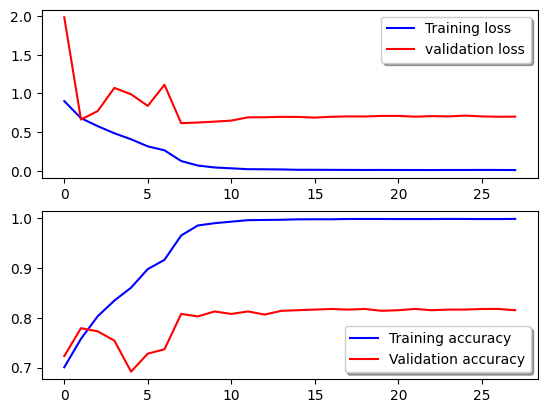

In [31]:
# Plotting the results on Graph
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [32]:
#Extaracting Features from last 4 layers of the model
model2 = Model(model.input,model.layers[-4].output)
predictions = model2.predict(X)
print(predictions[0])

313/313 [==============================] - 7s 19ms/step
[ 1.5280394e+01 -1.3174315e+01 -2.0447430e+01  2.4745802e+01
  1.6536966e+01 -4.2836089e+00 -1.3141879e+01 -7.6311960e+00
  1.0699841e+01  1.3090715e+01 -3.5470264e+00  8.8797933e-01
  2.0987537e+01  1.4515281e+01 -2.9186771e+00  4.0794744e+00
  1.2963472e+01  7.1858273e+00  1.8513540e+01 -2.6071489e+01
  1.5571532e+01 -1.1060498e+01 -1.0250589e+00  3.5096275e+01
 -4.5355868e+00  2.4448624e+01 -4.1205368e+00 -7.7382894e+00
 -5.3469224e+00  3.1522964e+01 -5.7379560e+00 -1.4757252e+01
  5.0768208e+01 -6.6042125e-01  4.4537991e+01 -1.7411209e+01
  9.6335135e+00  2.0395885e+01 -2.3993639e+01  4.5057644e+01
  1.1781442e+00  3.0540323e+01 -5.4159684e+00  8.1928234e+00
 -1.7005383e+01 -4.1927671e+00  2.9049715e+01 -1.0611197e+01
 -2.4412739e+01  1.7842648e+01 -2.4792126e+01 -1.8159523e+01
 -1.3478907e+01  2.7290443e+01  1.7087643e+01  1.6530429e+00
 -2.7278698e+01 -9.3290281e+00  2.8214622e+01  3.8825058e+01
  1.7601263e+01  1.4523513e+0

In [33]:
print(len(predictions[0]))

128


In [34]:
# Concatenating the predictions with final dataframe
data_df  = df
complete_data = pd.concat([data_df, pd.DataFrame(predictions)], axis=1)
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,...,118,119,120,121,122,123,124,125,126,127
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Project_files/Data/HAM1...,Benign keratosis-like lesions,2,...,5.606984,-3.461718,0.198521,-8.275889,-6.860916,11.584623,-8.451522,2.496100,3.128305,-3.366948
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Project_files/Data/HAM1...,Benign keratosis-like lesions,2,...,9.097523,-0.910388,-2.704264,6.133121,0.661963,1.028033,-1.394462,7.550729,0.996898,-4.079712
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Project_files/Data/HAM1...,Benign keratosis-like lesions,2,...,4.457727,-1.097807,-7.027039,-11.512035,-6.450685,11.031035,-7.966049,-0.071850,5.028385,2.631070
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Project_files/Data/HAM1...,Benign keratosis-like lesions,2,...,-0.450155,-1.098776,9.873013,13.459513,-2.104441,2.413704,-1.360327,14.701218,-4.696767,4.676081
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/Project_files/Data/HAM1...,Benign keratosis-like lesions,2,...,-4.827174,11.470120,-6.619008,-13.240500,-1.445212,18.444378,6.060988,-6.545034,14.225629,6.670472


In [35]:
# saving Models

model_json = model2.to_json()
with open("model_v2.json", "w") as json_file:
    json_file.write(model_json)

completemodel_json = model.to_json()
with open("completemodel1.json", "w") as json_file:
    json_file.write(completemodel_json)

In [36]:
#Saving Weights to disk.
model2.save_weights("model_v2_weights.h5")
print("Saved model to disk")

model.save_weights("completeweights.h5")
print("Saved model to disk")

Saved model to disk
Saved model to disk


In [37]:
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,...,118,119,120,121,122,123,124,125,126,127
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Project_files/Data/HAM1...,Benign keratosis-like lesions,2,...,5.606984,-3.461718,0.198521,-8.275889,-6.860916,11.584623,-8.451522,2.496100,3.128305,-3.366948
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Project_files/Data/HAM1...,Benign keratosis-like lesions,2,...,9.097523,-0.910388,-2.704264,6.133121,0.661963,1.028033,-1.394462,7.550729,0.996898,-4.079712
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Project_files/Data/HAM1...,Benign keratosis-like lesions,2,...,4.457727,-1.097807,-7.027039,-11.512035,-6.450685,11.031035,-7.966049,-0.071850,5.028385,2.631070
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Project_files/Data/HAM1...,Benign keratosis-like lesions,2,...,-0.450155,-1.098776,9.873013,13.459513,-2.104441,2.413704,-1.360327,14.701218,-4.696767,4.676081
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/Project_files/Data/HAM1...,Benign keratosis-like lesions,2,...,-4.827174,11.470120,-6.619008,-13.240500,-1.445212,18.444378,6.060988,-6.545034,14.225629,6.670472


In [38]:
# Making predictions from CNN
complete_data.to_csv('skin_cancer_v2.csv')
preds = model.predict(x_test)
preds

63/63 [==============================] - 2s 26ms/step


array([[7.04889148e-02, 3.09344530e-01, 8.81550685e-02, ...,
        3.13241303e-01, 1.30391270e-01, 3.68083045e-02],
       [3.16502119e-04, 2.74703838e-03, 1.06232325e-02, ...,
        9.78264332e-01, 6.45736046e-03, 6.51737850e-04],
       [3.98552977e-03, 4.74493299e-03, 1.23292925e-02, ...,
        9.48031783e-01, 1.78777277e-02, 6.34306017e-03],
       ...,
       [1.88162274e-04, 4.36155708e-04, 3.27318045e-03, ...,
        9.83945787e-01, 1.12095373e-02, 4.69165388e-04],
       [8.41217930e-04, 5.41996909e-03, 7.72189407e-04, ...,
        6.00065803e-04, 2.65901235e-05, 1.01748352e-04],
       [1.10833999e-02, 1.94259826e-02, 1.79514084e-02, ...,
        8.86321545e-01, 1.13995047e-02, 1.93992108e-02]], dtype=float32)

In [39]:
lst = []
for a in preds:
    lst.append(np.argmax(a))

In [40]:
print(lst)

[4, 4, 4, 4, 2, 4, 4, 2, 2, 4, 5, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 2, 1, 4, 4, 2, 4, 1, 2, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 1, 4, 4, 4, 6, 5, 4, 4, 0, 2, 4, 4, 4, 1, 4, 1, 4, 4, 5, 4, 3, 4, 4, 4, 4, 4, 1, 2, 4, 4, 5, 4, 4, 4, 4, 5, 1, 4, 5, 4, 1, 4, 2, 4, 4, 4, 5, 1, 4, 5, 5, 4, 0, 4, 5, 4, 4, 2, 4, 4, 2, 2, 4, 6, 4, 2, 5, 4, 4, 5, 4, 4, 4, 1, 6, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 0, 4, 4, 1, 4, 5, 1, 4, 4, 5, 4, 0, 1, 6, 4, 4, 4, 6, 1, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4, 5, 0, 4, 4, 2, 4, 4, 4, 2, 5, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 5, 4, 6, 4, 4, 4, 2, 5, 1, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4, 2, 4, 4, 2, 4, 4, 4, 4, 4, 0, 0, 4, 2, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4, 1, 4, 5, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 4, 4, 4, 4, 4, 4, 5, 0, 4, 5, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 1, 4, 5, 4, 5, 4, 2, 4, 4, 4, 4, 4, 5, 4, 4, 4, 2, 4, 4, 5, 2, 4, 4, 2, 4, 2, 2, 4, 4, 4, 2, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 2, 1, 4, 4, 4, 4, 4, 

In [41]:
confusion_matrix(lst,y_test)

array([[  31,    8,    8,    0,    2,    3,    0],
       [   9,   71,   14,    3,   13,    4,    0],
       [  11,    8,  142,    1,   37,   43,    2],
       [   4,    3,    0,   14,    3,    1,    0],
       [   5,    7,   38,    5, 1223,   57,    3],
       [   5,    5,   18,    0,   50,  115,    4],
       [   0,    1,    0,    0,   13,    0,   19]])

In [42]:
print(classification_report(y_test,lst))

              precision    recall  f1-score   support

           0       0.60      0.48      0.53        65
           1       0.62      0.69      0.65       103
           2       0.58      0.65      0.61       220
           3       0.56      0.61      0.58        23
           4       0.91      0.91      0.91      1341
           5       0.58      0.52      0.55       223
           6       0.58      0.68      0.62        28

    accuracy                           0.81      2003
   macro avg       0.63      0.65      0.64      2003
weighted avg       0.81      0.81      0.81      2003



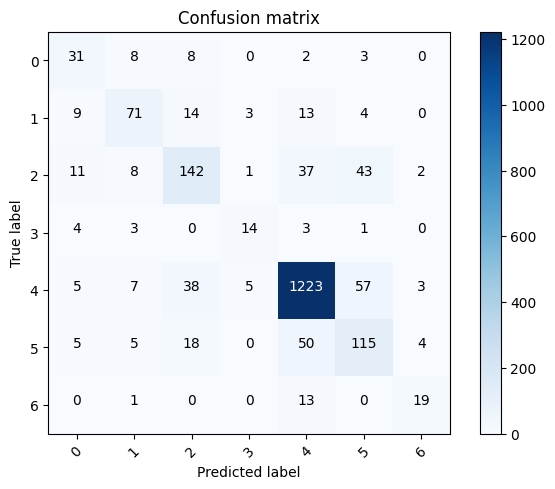

In [43]:
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# compute the confusion matrix
confusion_mtx = confusion_matrix(lst, y_test)



# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))